# Homework 2 - balancing & binning (deadline 27. 11. 2022, 23:59)

In short, the main task is to play with balancing and binning to obtain the best results for the binary classification task.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can!

However, we **strongly recommend and require** the following:
* Follow the assignment step by step. Number each step.
* Properly comment all your steps. Comments are evaluated for 2 points of the total together with the final presentation of the solution. However, it is not desirable to write novels! 
* Do not leave the task to the last minute.
* Hand in a notebook that has already been run (i.e. do not delete outputs before handing in).

## What are you supposed to do:

  1. Download the dataset [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
  1. Use 2 binning methods (on features of your choice, with your choice of parameters) and comment on its effects on classification performance. _(3 points)_
  1. Use at least 2 other data balancing techniques of your choice on the dataset and comment the classification results. **Just copied code from tutorial 4 will not be accepted.** _(6 points)_
  1. Run all classification tests at least three times - once for unbalanced original data, twice for balanced data (try at least 2 balancing techniques), compare those results and discuss (give a comment). _(5 points)_
  
All your steps and following code **have to be commented!** Comments are evaluated for _2 points_ together with the final presentation of the solution.

**If you do all this properly, you will obtain 16 points.**

## Comments

  * Please follow the technical instructions from https://courses.fit.cvut.cz/NI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, she can (!) give you another chance to rework your homework and to obtain more points. However, this is not a given, so do your best! :)
  * English is not compulsory.
  
## Data description

* The dataset can be downloaded [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
* The data are devoted to the binary classification task, the aim is to predict the probability that a driver will initiate an auto insurance claim in the next year.
* Target feature is called 'y' and signifies whether or not a claim was filed for that policy holder.
* To fulfill the task one does not need to know the meaning of predictors.
* Predictors that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation.
* While using [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), control the shuffling of data by random_state parameter. Do not use shuffle=False, probably never (can cause systematic error).
## Další FAQ:
* Klasifikátory použité v jednotlivých bodech mohou být různé.
* Zvolte vhodnou metriku pro vyhodnocení výsledků klasifikace.
* V bodě 2 a 3 porovnáváte metody mezi sebou, ne jejich efekt na neupravená data.
* Příznaky si volíte pouze v bodě 2 kvůli aplikaci binningu, v ostatních bodech

In [45]:
from typing import Literal
import itertools
from collections import Counter

import numpy as np
import pandas as pd

from scipy import stats, optimize

from sklearn import model_selection, linear_model, metrics, preprocessing, feature_selection
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.under_sampling import TomekLinks, NeighbourhoodCleaningRule
from imblearn.combine import SMOTETomek


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [22]:
RANDOM_STATE = 42

In [25]:
# from 4th lab
# code taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6f8757f7-ae28-4cc9-959f-a95a2ed810b1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

## 1.    Download the dataset here.

In [3]:
df = pd.read_csv('data.csv')
display(df.head())
df.shape

,y,xind_01,xind_02_cat,xind_03,xind_04_cat,xind_05_cat,xind_06_bin,xind_07_bin,xind_08_bin,xind_09_bin,...,xcalc_11,xcalc_12,xcalc_13,xcalc_14,xcalc_15_bin,xcalc_16_bin,xcalc_17_bin,xcalc_18_bin,xcalc_19_bin,xcalc_20_bin
0,0,2,1,5,1,6,0,1,0,0,...,4,0,2,8,0,0,0,1,1,0
1,0,2,1,6,0,0,0,0,0,1,...,9,2,3,7,0,0,1,0,0,0
2,0,2,1,9,0,0,1,0,0,0,...,5,0,2,6,0,1,0,1,1,0
3,0,1,1,6,0,0,1,0,0,0,...,3,0,4,8,0,0,1,0,0,0
4,0,1,1,5,1,0,0,1,0,0,...,4,3,1,2,0,1,0,0,1,0


(595212, 58)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 58 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   y             595212 non-null  int64  
 1   xind_01       595212 non-null  int64  
 2   xind_02_cat   595212 non-null  int64  
 3   xind_03       595212 non-null  int64  
 4   xind_04_cat   595212 non-null  int64  
 5   xind_05_cat   595212 non-null  int64  
 6   xind_06_bin   595212 non-null  int64  
 7   xind_07_bin   595212 non-null  int64  
 8   xind_08_bin   595212 non-null  int64  
 9   xind_09_bin   595212 non-null  int64  
 10  xind_10_bin   595212 non-null  int64  
 11  xind_11_bin   595212 non-null  int64  
 12  xind_12_bin   595212 non-null  int64  
 13  xind_13_bin   595212 non-null  int64  
 14  xind_14       595212 non-null  int64  
 15  xind_15       595212 non-null  int64  
 16  xind_16_bin   595212 non-null  int64  
 17  xind_17_bin   595212 non-null  int64  
 18  xind

In [5]:
df.describe(include='all')

,y,xind_01,xind_02_cat,xind_03,xind_04_cat,xind_05_cat,xind_06_bin,xind_07_bin,xind_08_bin,xind_09_bin,...,xcalc_11,xcalc_12,xcalc_13,xcalc_14,xcalc_15_bin,xcalc_16_bin,xcalc_17_bin,xcalc_18_bin,xcalc_19_bin,xcalc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.nunique()

y                   2
xind_01             8
xind_02_cat         5
xind_03            12
xind_04_cat         3
xind_05_cat         8
xind_06_bin         2
xind_07_bin         2
xind_08_bin         2
xind_09_bin         2
xind_10_bin         2
xind_11_bin         2
xind_12_bin         2
xind_13_bin         2
xind_14             5
xind_15            14
xind_16_bin         2
xind_17_bin         2
xind_18_bin         2
xreg_01            10
xreg_02            19
xreg_03          5013
xcar_01_cat        13
xcar_02_cat         3
xcar_03_cat         3
xcar_04_cat        10
xcar_05_cat         3
xcar_06_cat        18
xcar_07_cat         3
xcar_08_cat         2
xcar_09_cat         6
xcar_10_cat         3
xcar_11_cat       104
xcar_11             5
xcar_12           184
xcar_13         70482
xcar_14           850
xcar_15            15
xcalc_01           10
xcalc_02           10
xcalc_03           10
xcalc_04            6
xcalc_05            7
xcalc_06           11
xcalc_07           10
xcalc_08  

## 2. Use 2 binning methods (on features of your choice, with your choice of parameters) and comment on its effects on classification performance. (3 points) - Tzn. jeden druh klasifikátoru natrénovaný pro každý binning a srovnání těchto dvou klasifikátorů a efektu a metod biningu.

since `-1` are NaNs, which could affect the binning, lets 1st convert it.

In [7]:
# df = df.replace(-1,np.NaN)

Get a list of features, with more than 20 unique values

In [8]:
df.nunique()[df.nunique() > 20]

xreg_03         5013
xcar_11_cat      104
xcar_12          184
xcar_13        70482
xcar_14          850
xcalc_10          26
xcalc_14          24
dtype: int64

Make plots for these columns

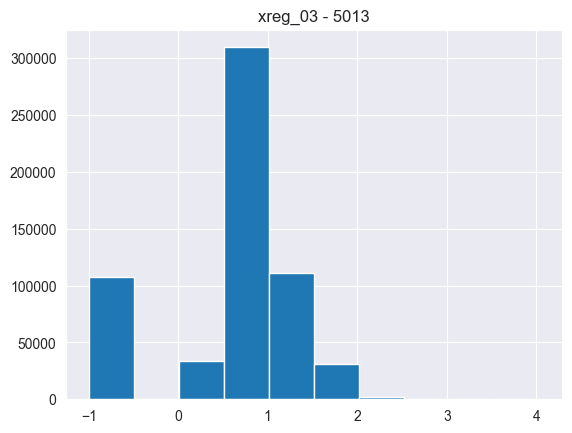

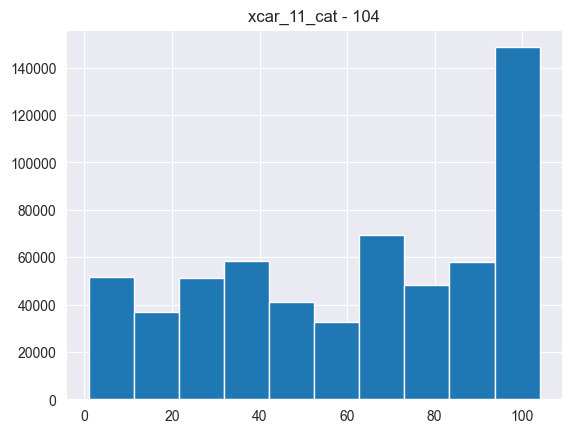

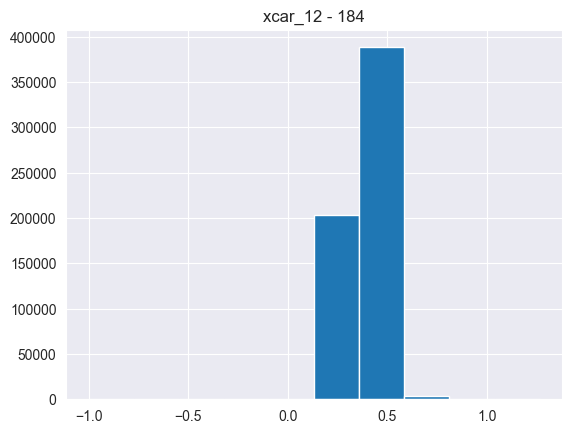

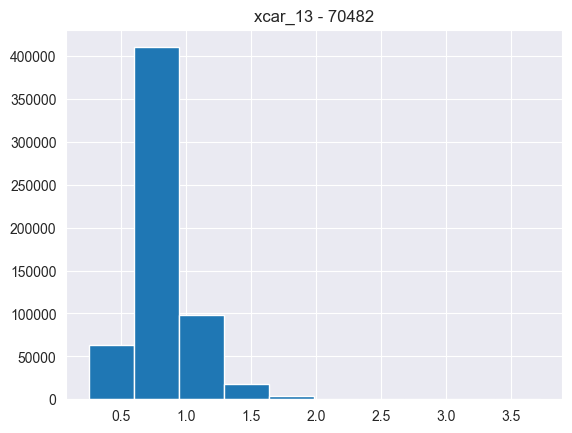

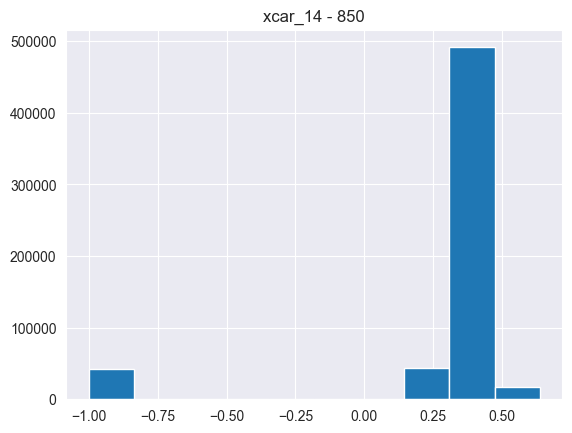

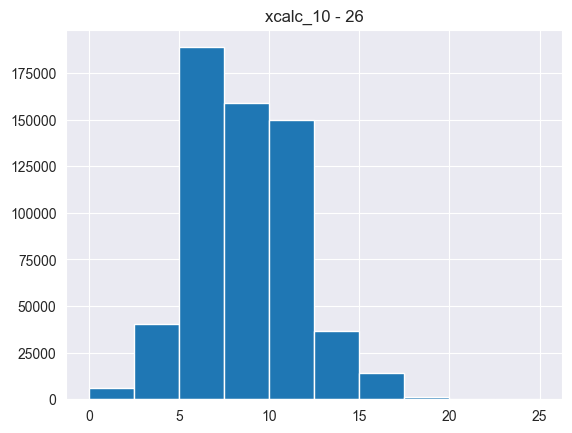

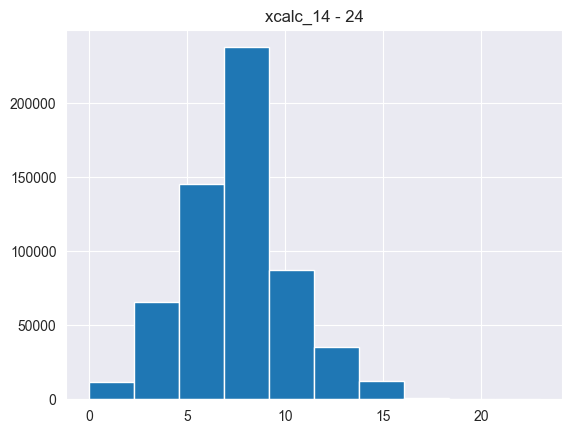

In [9]:
for col in list(df.columns[df.nunique() > 20]):
    # print(col)
    fig, ax = plt.subplots()
    ax.set_title(f"{col} - {df[col].nunique()}")
    df[col].hist(ax=ax)
    # df[col].value_counts()

lets apply binning on all of these except `xcar_11_cat` since it is a categorical value and binning might not make much sense (if it is not a linear arrangement).

In [10]:
binning_cols = [
    'xreg_03',
    'xcar_12',
    'xcar_13',
    'xcar_14',
    'xcalc_10',
    'xcalc_14'
]

quantile_binned_cols = []
uniform_binned_cols = []

In [11]:
# helper function for binning
def binatize(col_name:str, bin_method: Literal['quantile', 'uniform']) -> str:
    out_col_name = f"{col_name}_{bin_method}"
    est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy=bin_method)
    df[out_col_name] = est.fit_transform(df[[col_name]])
    return out_col_name

for each of those 6 columns, lets bin them into 5 bins for now, using both `equal high` (quantile) and `equal width` (uniform)

In [12]:
for col in binning_cols:
    quantile_binned_cols.append(binatize(col, 'quantile'))
    uniform_binned_cols.append(binatize(col, 'uniform'))

/Users/jakubkucera/Documents/NI-PDD/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:209: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/jakubkucera/Documents/NI-PDD/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:209: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/jakubkucera/Documents/NI-PDD/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:209: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/

In [16]:
classifiers = {
    "k-Nearest Neighbors": KNeighborsClassifier(3),
    "Decision Tree": DecisionTreeClassifier(), # gini criterion
}

=== k-Nearest Neighbors ===


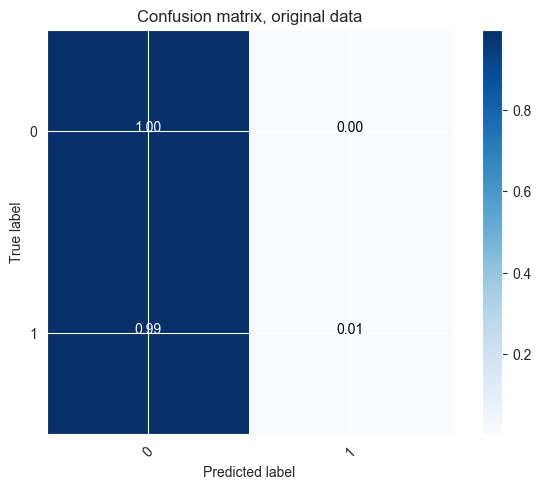


Original data 
Accuracy:  0.9596320641787597 
F1-score:  0.011112254347155057


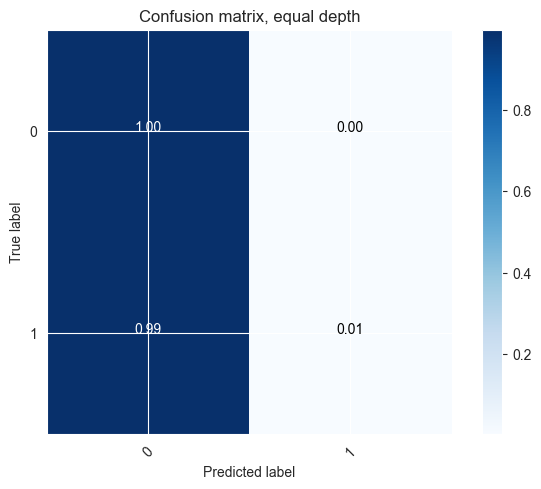


Bins with equal depth 
Accuracy:  0.9598924753764412 
F1-score:  0.013431139580535179


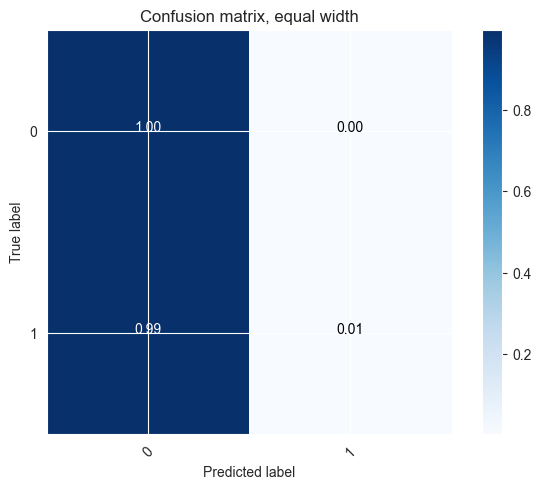


Bins with equal width 
Accuracy:  0.9599302770019111 
F1-score:  0.009551495016611294
=== Decision Tree ===


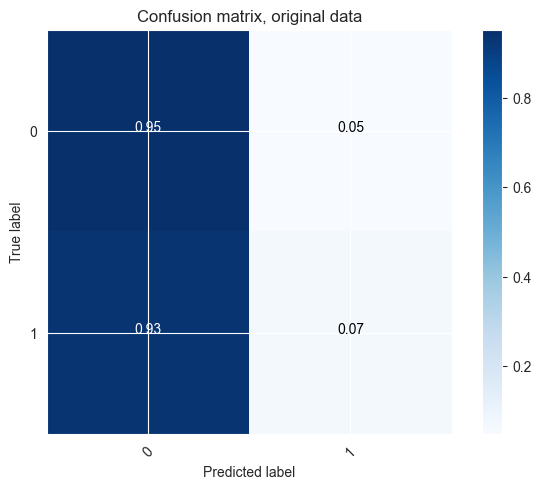


Original data 
Accuracy:  0.9192305269126573 
F1-score:  0.05652045922873123


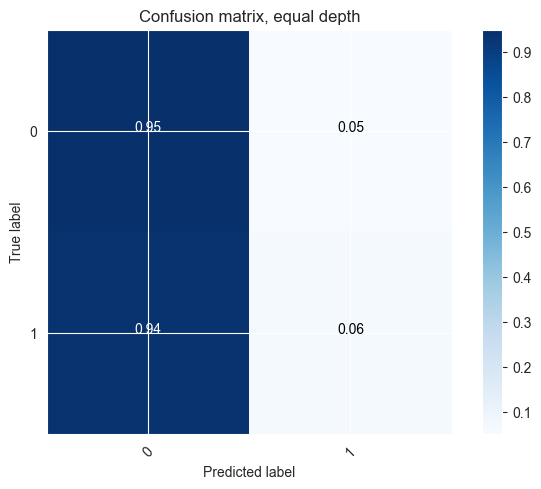


Bins with equal depth 
Accuracy:  0.9170674338996577 
F1-score:  0.05286132297213028


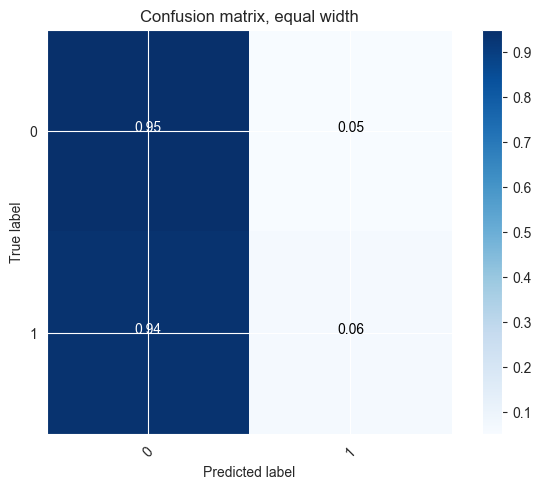


Bins with equal width 
Accuracy:  0.9164542075309239 
F1-score:  0.05258394855918075


In [27]:
# compare discretization (AgeBin3, AgeBin4) by classification model
# clf = DecisionTreeClassifier()


y = list(df['y'])

for name, clf in classifiers.items():
    print(f"=== {name} ===")

    # Original data
    X = df.drop(['y', *quantile_binned_cols, *uniform_binned_cols], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=RANDOM_STATE)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cnf_matrix, classes=[0,1], title='Confusion matrix, original data')
    print('\nOriginal data \nAccuracy: ', accuracy_score(y_test, y_pred), '\nF1-score: ', f1_score(y_test, y_pred))

    # Quantile bins
    X = df.drop(['y', *binning_cols, *uniform_binned_cols], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=RANDOM_STATE)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cnf_matrix, classes=[0,1], title='Confusion matrix, equal depth')
    print('\nBins with equal depth \nAccuracy: ', accuracy_score(y_test, y_pred), '\nF1-score: ', f1_score(y_test, y_pred))

    # Uniform bins
    X = df.drop(['y', *quantile_binned_cols, *binning_cols], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=RANDOM_STATE)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cnf_matrix, classes=[0,1], title='Confusion matrix, equal width')
    print('\nBins with equal width \nAccuracy: ', accuracy_score(y_test, y_pred), '\nF1-score: ', f1_score(y_test, y_pred))

    print(50*"=")

### Decision tree
Both `equal depth` and `equal witdh` should not have a big effect on Decision tree classification, since Decision tree kind of does binning by itself. And this is supported by the results, which are very close to each other. If we look at training time, it should be improved, since the condition in each node (in cases of binned columns), will affect the result for only 4 different ranges of values (between different bins) as opposed to an infinite options (when size of dataset -> inf.)

### KNN

As for KNN, the accuracy can be actually worse, since it's all about distances and now, there are less distinctions between them. As for training+predicting time, that should probably be roughly the same, sice distances still need to ba calculated.

## 3.    Use at least 2 other data balancing techniques of your choice on the dataset and comment the classification results. Just copied code from tutorial 4 will not be accepted. (6 points) - Tzn. jeden druh klasifikátoru natrénovaný pro každý balancing a srovnání těchto dvou klasifikátorů a efektu a metod balancování.
\+
## 4.    Run all classification tests at least three times - once for unbalanced original data, twice for balanced data (try at least 2 balancing techniques), compare those results and discuss (give a comment). (5 points) - Tzn. jeden druh klasifikátoru natrénovaný pro nebalancovaná data a 2x pro balancovaná data (zde je překryv s bodem 3 a můžete využít výsledky z bodu 3, jen zachovejte přehlednost) -> 3 klasifikátory, pro které srovnáváte a diskutujete výsledky.

In [34]:
# reload data to delete new binned columns
df = pd.read_csv('data.csv')

lets check if the `y` is balanced

In [35]:
# print(Counter(df.y))
df.y.value_counts()

0    573518
1     21694
Name: y, dtype: int64

woah, that is very unbalanced

lets try to predict using Decision tree without any modifications and take a look at the confusion matrix

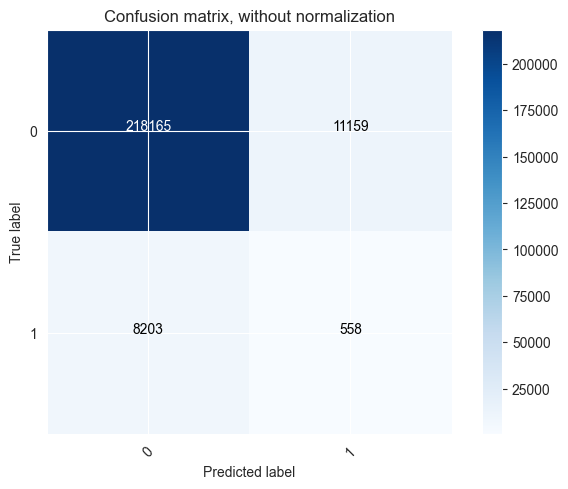

In [38]:
# prep data
y = list(df['y'])
X = df.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=RANDOM_STATE)

# train + predict
clf = DecisionTreeClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred) # check the order -> (y_true, y_pred)

plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Confusion matrix, with normalization')

print accuracy and f1 score

In [39]:
print('Accuracy: ', accuracy_score(y_test, y_pred),'\nF1-score: ', f1_score(y_test, y_pred))

Accuracy:  0.9186761030724321 
F1-score:  0.0544975095224143


F1-Score is more important for unbalanced data, so it is quite bad

### 3.1

Since I am supposed to try 2 balancing techniques, lets pick 1 under sampling and 1 over sampling

For under-sampling I'd use TOMEK, but that might look too similar to the 4th lab, so lets try Neighbourhood Cleaning Rule. NCL is kind of a combination of ENN and a k-NN.

/Users/jakubkucera/Documents/NI-PDD/.venv/lib/python3.10/site-packages/imblearn/under_sampling/_prototype_selection/_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  nnhood_label, _ = mode(nnhood_label, axis=1)


Counter({0: 309555, 1: 12933})


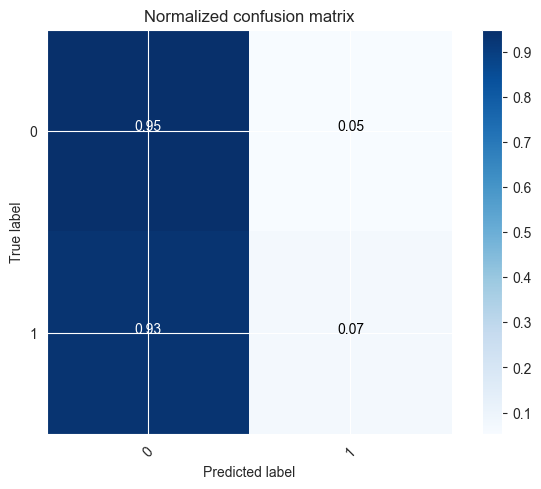

Accuracy:  0.9158493815234056 
F1-score:  0.05695457754765827


In [48]:
# tl = NeighbourhoodCleaningRule(sampling_strategy='not minority')
tl = NeighbourhoodCleaningRule(sampling_strategy='auto')
X_tomeked, y_tomeked = tl.fit_resample(X_train, y_train)


# y_tomeked.value_counts()
print(Counter(y_tomeked))

# classify
y_pred = clf.fit(X_tomeked, y_tomeked).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')
print('Accuracy: ', accuracy_score(y_test, y_pred),'\nF1-score: ', f1_score(y_test, y_pred))

Well, that didnt really help, in terms of F1-Score, only barely.
From `Counter({0: 309555, 1: 12933})` we can see that there has been some under-sampling, but it reduced data from both `0` and `1` "categories", actually it is now even more unbalanced (original ration 0.04177932839075447,  new ration 0.037826188541597645).
This might mean that a different under-sampling technique might have better results.

Now onto oversampling, which is said to have usually better results. The choice here apears to be quictly simple: `Smote`. However I'll combine it with Tomek links, which could help deliver better results.

Counter({0: 344194, 1: 344194})


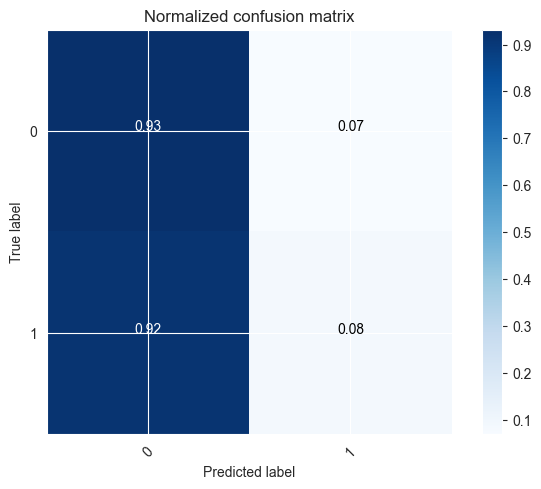

Accuracy:  0.9003255139971019 
F1-score:  0.05862985441707327


In [47]:
tl = SMOTETomek(sampling_strategy='auto') # default - will remove the sample from the majority class
X_smoted, y_smoted = tl.fit_resample(X_train, y_train)


# y_tomeked.value_counts()
print(Counter(y_smoted))

# classify
y_pred = clf.fit(X_smoted, y_smoted).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')
print('Accuracy: ', accuracy_score(y_test, y_pred),'\nF1-score: ', f1_score(y_test, y_pred))

Well, that is a definitely better than NCL, but I would have still expected better results. Perhaps a different method could deliver better results, or the actuall dataset is not that great. Also to note, we might get better results, if we would use the binned dataset and not the original one.

Just to note: from `Counter({0: 344194, 1: 344194})` we can see that the data set is at least balanced now, literally 1:1
